## 1. Kütüphane Yükleme ve Veri Seti Okuma

In [1]:
## Import Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik stilini ayarlama
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Veri Setini Yükleme
df = pd.read_csv('../data/google_play_store_dataset.csv')



Bu bölümde, projenin temelini oluşturan Python kütüphaneleri (Pandas, Numpy, Matplotlib, Seaborn) çalışma ortamına dahil edilmiştir.
* **Pandas:** Veri manipülasyonu ve analizi için.
* **Numpy:** Sayısal işlemler için.
* **Matplotlib & Seaborn:** Veri görselleştirme ve grafikler için.

Kaggle'dan indirilen `google_play_store_dataset.csv` dosyası okunarak bir DataFrame'e dönüştürülmüş ve veri setinin genel yapısı incelenmiştir. İlk bakışta `Reviews`, `Size`, `Installs` ve `Price` sütunlarının sayısal olması gerekirken **Object (String)** formatında olduğu tespit edilmiştir.

##  2. Veriyi Tanıma ve İlk İnceleme (Data Understanding)

In [ ]:


# 1. Veri setinin genel yapısına bir bakış (Satır/Sütun sayısı ve Veri Tipleri)
print("--- Veri Seti Genel Bilgileri ---")
df.info()

# 2. Kategorilerin İncelenmesi ve Tutarlılık Kontrolü
# Kategori sütunundaki eşsiz değerleri alıyoruz
unique_categories = df['Category'].unique()
print(f"\n--- Kategori Analizi ---")
print(f"Toplam Kategori Sayısı: {len(unique_categories)}")


# List comprehension ile şüpheli (sayısal) kategorileri bul
suspicious_cats = [cat for cat in unique_categories if str(cat).replace('.', '', 1).isdigit()]

if suspicious_cats:
    print(f"\n[!] UYARI: Veri setinde beklenmeyen sayısal kategoriler tespit edildi: {suspicious_cats}")
    print("Hatalı veri içeren satırlar getiriliyor...")
    
    # Hatalı satırları filtrele ve göster
    anomalies = df[df['Category'].isin(suspicious_cats)]
    display(anomalies) 
else:
    print("\nKategori isimlerinde herhangi bir anomaliye (sayısal değer) rastlanmadı.")

--- Veri Seti Genel Bilgileri ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB

--- Kategori Analizi ---
Toplam Kategori Sayısı: 34

[!] UYARI: Veri setinde beklenmeyen sayısal kategoriler tespit edildi: ['1.

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


### 🕵️‍♂️ Veri Ön İşleme: Anomali Tespiti ve Analizi

**1. Durum Tespiti (Observation)**
Veri setinin yapısal tutarlılığını kontrol etmek amacıyla yapılan `Category` sütunu analizinde, metin (string) olması gereken kategori isimleri arasında sayısal bir ifade olan **'1.9'** tespit edilmiştir.

**2. Hata Teşhisi (Diagnosis)**
Tespit edilen `10472` numaralı satır (index) detaylı incelendiğinde, verilerin **Sütun Kayması (Column Shift)** hatasına uğradığı görülmüştür:

* **Category:** `'1.9'` değerini almıştır. *(Aslında Rating değeridir, kategori verisi eksik olduğu için sola kaymıştır.)*
* **Rating:** `19.0` değerini almıştır. *(Maksimum puan 5.0 iken 19.0 olması imkansızdır.)*
* **Installs:** `'Free'` olarak görünmektedir. *(Sayısal olması gereken sütuna Type verisi kaymıştır.)*

**3. Aksiyon Kararı (Action)**
Bu satır yapısal olarak bozuktur ve içerdiği `19.0` gibi uç değerler istatistiksel analizleri (örneğin ortalama puan hesabını) saptıracaktır. Bu nedenle ilgili satırın **veri setinden silinmesine (drop)** karar verilmiştir.

## 3. Veri Temizleme ve Dönüştürme (Data Cleaning & Transformation)


In [ ]:

# 1. ADIM: Hatalı satırdan kurtulma
# '10472' nolu indeksi siliyoruz.
df.drop(10472, inplace=True)
print("Hatalı satır (Index 10472) veri setinden başarıyla silindi.\n")

# 2. ADIM: Veri Tiplerini Düzeltme
# Reviews: Object -> Integer
df['Reviews'] = df['Reviews'].astype(int)

# Installs: '+', ',' işaretlerini kaldırıp -> Integer
df['Installs'] = df['Installs'].str.replace('+', '').str.replace(',', '').astype(int)

# Price: '$' işaretini kaldırıp -> Float
df['Price'] = df['Price'].str.replace('$', '').astype(float)

# 3. ADIM: 'Size' (Boyut) Sütununu Düzeltme (Fonksiyon ile)
# 'M' -> Megabyte (x 10^6), 'k' -> Kilobyte (x 10^3), 'Varies with device' -> NaN
def clean_size(size):
    if 'M' in size:
        return float(size.replace('M', '')) * 1_000_000
    elif 'k' in size:
        return float(size.replace('k', '')) * 1_000
    elif 'Varies with device' in size:
        return np.nan
    else:
        return float(size) # Zaten sayıysa direkt döndür

df['Size'] = df['Size'].map(clean_size)

# Kontrol: Temizlik sonrası veri setinin son durumu
print("--- Temizlik Sonrası Veri Bilgileri ---")
df.info()

Hatalı satır (Index 10472) veri setinden başarıyla silindi.

--- Temizlik Sonrası Veri Bilgileri ---
<class 'pandas.core.frame.DataFrame'>
Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          9366 non-null   float64
 3   Reviews         10840 non-null  int64  
 4   Size            9145 non-null   float64
 5   Installs        10840 non-null  int64  
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  float64
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 1.2+ MB


###  Veri Temizleme ve Tip Dönüştürme Sonuçları

Yapılan temizlik işlemleri sonucunda veri seti analize uygun hale getirilmiştir. `df.info()` çıktısı üzerinden yapılan kontroller şu şekildedir:

**1. Hatalı Veri Temizliği (Data Cleaning)**
* Tespit edilen **Index 10472** (Sütun kayması olan satır) başarıyla silinmiştir.
* Toplam kayıt sayısı **10841'den 10840'a** düşmüştür.

**2. Veri Tipi Dönüşümleri (Type Casting)**
Analiz yapabilmek adına `Object` (metin) olan sütunlar uygun sayısal formatlara çevrilmiştir:
* **Reviews:** `int64` (Tam sayı) formatına dönüştürüldü.
* **Installs:** `int64` formatına dönüştürüldü (Artı ve virgül işaretleri temizlendi).
* **Price:** `float64` (Ondalıklı sayı) formatına dönüştürüldü.

**3. Önemli Not: 'Size' Sütunu**
* `Size` sütunu `float64` formatına çevrilmiştir.
* **Dikkat:** "Non-Null Count" değerinin **9145**'e düştüğü görülmektedir. Bunun sebebi, *"Varies with device"* (Cihaza göre değişir) yazan verilerin sayısal karşılığı olmadığı için bilinçli olarak **NaN (Boş)** değere dönüştürülmesidir. Bu boşluklar bir sonraki aşamada (Eksik Veri Analizi) ele alınacaktır

## 4. Eksik Veri Analizi ve Doldurma (Missing Value Handling)

In [5]:

print("--- Eksik Veri Sayıları (İşlem Öncesi) ---")
print(df.isnull().sum())

# Strateji 1: 'Rating' sütunundaki boşlukları ortalama ile doldurma
rating_mean = df['Rating'].mean()
df['Rating'].fillna(rating_mean, inplace=True)
print(f"\nBilgi: Eksik 'Rating' değerleri ortalama puan ({rating_mean:.2f}) ile dolduruldu.")

# Strateji 2: Çok az sayıda eksiği olan kategorik sütunları temizleme
# (Type, Current Ver ve Android Ver sütunlarında sadece birkaç eksik var, bunları siliyoruz)
df.dropna(subset=['Type', 'Current Ver', 'Android Ver'], inplace=True)

# Strateji 3: 'Size' sütunu (Opsiyonel - Şimdilik olduğu gibi bırakıyoruz veya analizde kullanacaksak doldurabiliriz)
# Not: 'Size' sütununda 'Varies with device' nedeniyle oluşan NaN'lar şimdilik kalabilir.

print("\n--- Eksik Veri Sayıları (İşlem Sonrası) ---")
print(df.isnull().sum())

print(f"\nGüncel Veri Seti Boyutu: {df.shape}")

--- Eksik Veri Sayıları (İşlem Öncesi) ---
App                  0
Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

Bilgi: Eksik 'Rating' değerleri ortalama puan (4.19) ile dolduruldu.

--- Eksik Veri Sayıları (İşlem Sonrası) ---
App                  0
Category             0
Rating               0
Reviews              0
Size              1694
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          0
Android Ver          0
dtype: int64

Güncel Veri Seti Boyutu: (10829, 13)


C:\Users\fatmanur\AppData\Local\Temp\ipykernel_12956\2960130617.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Rating'].fillna(rating_mean, inplace=True)


### 📉 Eksik Veri Analizi ve Tamamlama Raporu

Veri setindeki eksik değerler (NaN) incelenmiş ve veri kaybını minimumda tutacak stratejilerle aşağıdaki işlemler uygulanmıştır:

**1. Rating (Puan) Sütunu Stratejisi: Ortalama ile Doldurma**
* **Tespit:** `Rating` sütununda **1474** adet eksik veri (%13.5) bulunmaktaydı.
* **İşlem:** Bu satırları silmek büyük veri kaybına yol açacağı için, eksik alanlar veri setinin genel puan ortalaması olan **4.19** değeri ile dolduruldu.
* **Sonuç:** Eksik veri sayısı 0'a indirildi ve veri bütünlüğü korundu.

**2. Minör Eksikliklerin Giderilmesi**
* **Tespit:** `Type`, `Current Ver` ve `Android Ver` sütunlarında toplamda sadece **11** adet eksik veri tespit edildi.
* **İşlem:** Bu sayı istatistiksel olarak ihmal edilebilir düzeyde (binde 1'den az) olduğu için ilgili satırlar veri setinden çıkarıldı (Drop).

**3. Size (Boyut) Sütunu Durumu**
* **Not:** `Size` sütununda **1694** adet eksik veri görülmektedir.
* **Açıklama:** Bu boşluklar, orijinal verideki *"Varies with device"* (Cihaza göre değişir) ifadesinden kaynaklanmaktadır. Bu bir veri kaybı değil, verinin doğası gereği bilinmeyen bir durumdur. Bu aşamada olduğu gibi bırakılmıştır.

**4. Veri Setinin Son Durumu**
* İşlemler sonucunda toplam satır sayısı **10829** olarak güncellenmiştir. Veri seti artık analiz ve görselleştirme için temiz haldedir.

## 5. Veri Görselleştirme: Kategori Analizi

--- En Popüler 10 Kategori (Sayısal) ---
Category
FAMILY             1968
GAME               1144
TOOLS               841
MEDICAL             463
BUSINESS            460
PRODUCTIVITY        424
PERSONALIZATION     390
COMMUNICATION       387
SPORTS              384
LIFESTYLE           382
Name: count, dtype: int64


C:\Users\fatmanur\AppData\Local\Temp\ipykernel_12956\611763247.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')


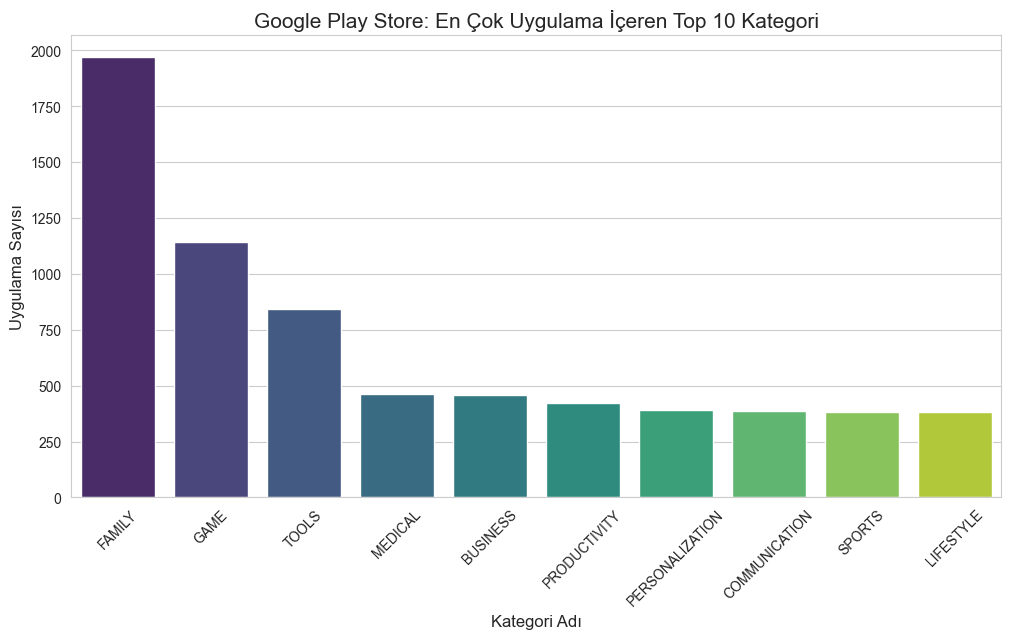

In [6]:

# 1. En çok uygulamaya sahip ilk 10 kategoriyi bulalım
top_categories = df['Category'].value_counts().head(10)

print("--- En Popüler 10 Kategori (Sayısal) ---")
print(top_categories)

# 2. Görselleştirme (Bar Chart)
plt.figure(figsize=(12, 6)) # Grafik boyutunu ayarlıyoruz
sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')

# Grafik Başlıkları ve Eksen İsimleri
plt.title('Google Play Store: En Çok Uygulama İçeren Top 10 Kategori', fontsize=15)
plt.xlabel('Kategori Adı', fontsize=12)
plt.ylabel('Uygulama Sayısı', fontsize=12)
plt.xticks(rotation=45) # Kategori isimleri sığsın diye 45 derece eğiyoruz
plt.show()

### 📊 Kategori Dağılımı ve Pazar Analizi

**1. Pazar Liderliği (Market Dominance)**
Veri seti üzerindeki kategori dağılımı incelendiğinde, pazarın **"FAMILY" (Aile)** ve **"GAME" (Oyun)** kategorileri tarafından domine edildiği görülmektedir:
* **FAMILY:** **1968** uygulama ile açık ara en büyük kategoridir.
* **GAME:** **1144** uygulama ile ikinci sırada yer almaktadır.
* *Yorum:* Bu durum, Google Play Store kullanıcılarının cihazlarını yoğunlukla eğlence, çocuklar için içerik ve oyun odaklı kullandığını göstermektedir.

**2. Araçlar ve Üretkenlik (Utility & Productivity)**
Eğlence sektörünü **"TOOLS" (Araçlar)** kategorisi **841** uygulama ile takip etmektedir. Bu veri, kullanıcıların telefonlarını sadece oyun için değil, günlük işlevsel yardımcılar (Hesap makinesi, VPN, Dosya yöneticisi vb.) için de yoğun şekilde kullandığını kanıtlar.

**3. Niş Alanlar**
İlk 3 kategoriden sonra keskin bir düşüş gözlemlenmektedir. **MEDICAL (Tıp)** ve **BUSINESS (İş)** kategorileri **~460** uygulama bandında seyrederek daha spesifik/niş bir kitleye hitap etmektedir.

**Sonuç:**
Uygulama geliştiricileri için en yüksek rekabet "Family" ve "Game" alanındayken; "Medical" veya "Business" gibi alanlar daha az rekabetin olduğu ancak daha odaklı (niş) pazarlar olarak öne çıkmaktadır.

## 6. Veri Görselleştirme: Puan (Rating) Dağılımı

Ortalama Puan: 4.19
Medyan Puan: 4.20


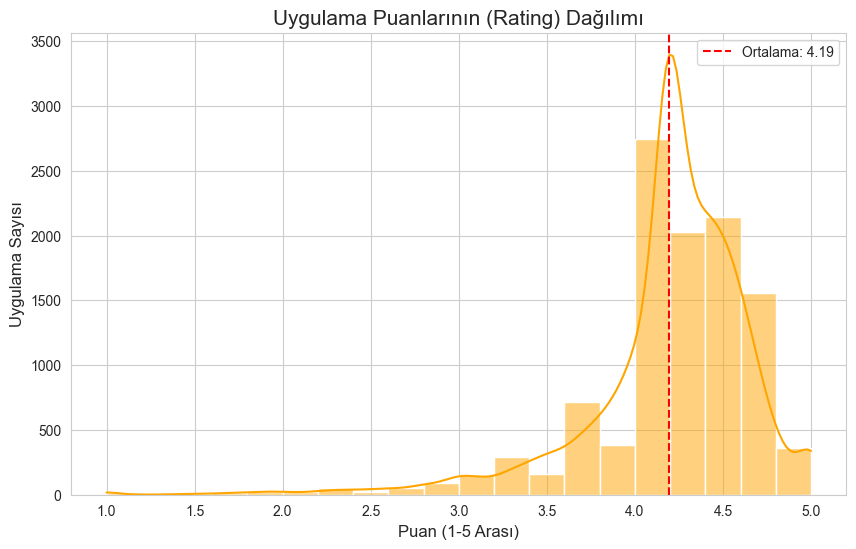

In [7]:
# İstatistiksel özet
rating_mean = df['Rating'].mean()
rating_median = df['Rating'].median()

print(f"Ortalama Puan: {rating_mean:.2f}")
print(f"Medyan Puan: {rating_median:.2f}")

# Histogram Grafiği
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'], bins=20, kde=True, color='orange')

# Ortalama çizgisini ekleyelim
plt.axvline(rating_mean, color='red', linestyle='--', label=f'Ortalama: {rating_mean:.2f}')

plt.title('Uygulama Puanlarının (Rating) Dağılımı', fontsize=15)
plt.xlabel('Puan (1-5 Arası)', fontsize=12)
plt.ylabel('Uygulama Sayısı', fontsize=12)
plt.legend()
plt.show()

### 📈 Kullanıcı Memnuniyeti ve Puan (Rating) Analizi

**1. İstatistiksel Özet**
* **Ortalama Puan:** 4.19 / 5.0
* **Medyan Puan:** 4.20 / 5.0
* **Yorum:** Medyan ve ortalamanın birbirine bu kadar yakın olması, veri setinde tutarlı bir yığılma olduğunu gösterir.

**2. Dağılımın Karakteristiği (Sola Çarpık - Left Skewed)**
Histogram incelendiğinde, puanların 1.0 ile 3.0 arasında çok düşük seyrettiği, ancak **4.0 ile 4.7** aralığında zirve yaptığı görülmektedir.
* Bu durum, marketteki uygulamaların genel kalitesinin yüksek olduğunu veya kullanıcıların beğendikleri uygulamalara puan verme eğiliminin daha yüksek olduğunu (Survival Bias) gösterir.

**3. Başarı Kriteri**
Google Play Store evreninde "ortalama" bir uygulama 3.0 değil, **4.2** puandır. Dolayısıyla 4.0'ın altında puana sahip bir uygulama, teknik olarak "başarısız" veya "sorunlu" olarak nitelendirilebilir.

## 7. Veri Görselleştirme: Ücretli vs Ücretsiz (Type) Analizi

--- Uygulama Türü Dağılımı ---
Type
Free    10032
Paid      797
Name: count, dtype: int64


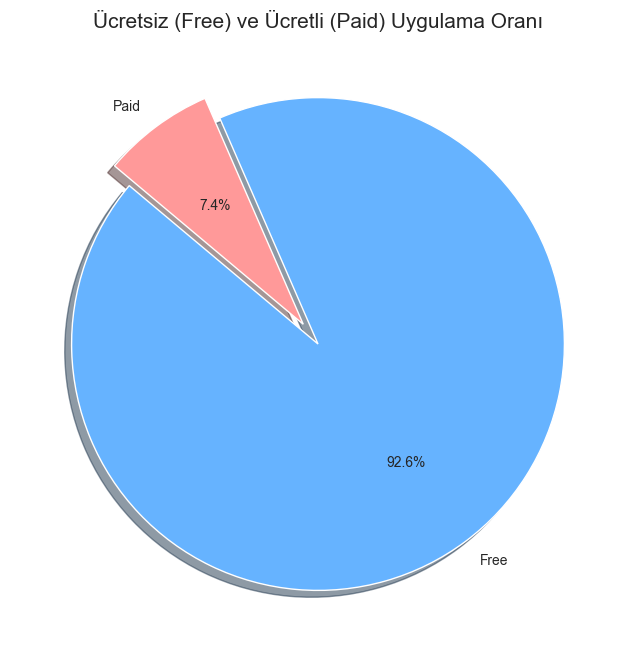

In [ ]:
# 1. Sayıları hesaplayalım
type_counts = df['Type'].value_counts()

print("--- Uygulama Türü Dağılımı ---")
print(type_counts)

# 2. Pasta Grafiği (Pie Chart)
plt.figure(figsize=(5, 5))
plt.pie(
    type_counts.values,
    labels=type_counts.index,
    autopct='%1.1f%%', # Yüzdelik dilimleri göster
    startangle=140,
    colors=['#66b3ff', '#ff9999'], # Mavi ve Kırmızı tonları
    explode=(0, 0.1), # 'Paid' dilimini biraz dışarı çıkararak vurgula
    shadow=True
)

plt.title('Ücretsiz (Free) ve Ücretli (Paid) Uygulama Oranı', fontsize=15)
plt.show()